In [1]:
import demo_util
import numpy as np
import torch
from PIL import Image
import imagenet_classes
from IPython.display import display
import os
from huggingface_hub import hf_hub_download
from modeling.maskgit import ImageBert
from modeling.titok import TiTok

/autofs/bal34/cxin/DATA8014/DATA8014/modeling/modules/losses.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)


attention mode is flash


/autofs/bal34/cxin/DATA8014/DATA8014/modeling/quantizer/quantizer.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/autofs/bal34/cxin/DATA8014/DATA8014/modeling/quantizer/quantizer.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/autofs/bal34/cxin/DATA8014/DATA8014/modeling/quantizer/quantizer.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/autofs/bal34/cxin/DATA8014/DATA8014/modeling/quantizer/quantizer.py:123: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/autofs/bal34/cxin/DATA8014/DATA8014/modeling/quantizer/quantizer.py:127: FutureWarning: `torch.cuda.amp.a

In [2]:
# load the pretrained models from huggingface
# supported tokenizer: [tokenizer_titok_l32_imagenet, tokenizer_titok_b64_imagenet, tokenizer_titok_s128_imagenet]
# titok_tokenizer = TiTok.from_pretrained("yucornetto/tokenizer_titok_l32_imagenet")
# titok_generator = ImageBert.from_pretrained("yucornetto/generator_titok_l32_imagenet")

"""tokenizer = TiTok.from_pretrained(
    "yucornetto/tokenizer_titok_l32_imagenet",
    cache_dir="/root/users/jusjus/1d-tokenizer/jusjus"
)

# Specify the cache directory when loading a model
model = TiTok.from_pretrained(
    "yucornetto/generator_titok_l32_imagenet",
    cache_dir="/root/users/jusjus/1d-tokenizer/jusjus"
)"""

# or alternatively, downloads from hf
# hf_hub_download(repo_id="fun-research/TiTok", filename="tokenizer_titok_l32.bin", local_dir="./")
# hf_hub_download(repo_id="fun-research/TiTok", filename="generator_titok_l32.bin", local_dir="./")

'tokenizer = TiTok.from_pretrained(\n    "yucornetto/tokenizer_titok_l32_imagenet",\n    cache_dir="/root/users/jusjus/1d-tokenizer/jusjus"\n)\n\n# Specify the cache directory when loading a model\nmodel = TiTok.from_pretrained(\n    "yucornetto/generator_titok_l32_imagenet",\n    cache_dir="/root/users/jusjus/1d-tokenizer/jusjus"\n)'

In [3]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.manual_seed(0)

## Prepare the TiTok models

In [4]:
config = demo_util.get_config("configs/infer/titok_l32.yaml")

In [5]:
import os
# os.environ['http_proxy'] = "http://127.0.0.1:8123" 
# os.environ['https_proxy'] = "http://df-127.0.0.1:8123" 
os.environ["HTTP_PROXY"] = ""
os.environ["HTTPS_PROXY"] = ""
os.environ["ALL_PROXY"] = ""

In [6]:
# supported tokenizer: [tokenizer_titok_l32_imagenet, tokenizer_titok_b64_imagenet, tokenizer_titok_s128_imagenet]
titok_tokenizer = TiTok.from_pretrained("hug/tokenizer_titok_l32_imagenet", config = config)
titok_tokenizer.eval()
titok_tokenizer.requires_grad_(False)
# or alternatively, downloads from hf

# hf_hub_download(repo_id="fun-research/TiTok", filename="tokenizer_titok_l32.bin", local_dir="./")
# titok_tokenizer = demo_util.get_titok_tokenizer(config)
# titok_tokenizer.eval()
# titok_tokenizer.requires_grad_(False)
print(titok_tokenizer)

Loading weights from local directory
TiTok(
  (encoder): TiTokEncoder(
    (patch_embed): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): ModuleList(
      (0-23): 24 x ResidualAttentionBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (ln_post): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (conv_out): Conv2d(1024, 12, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): TiTokDecoder(
    (decode

In [7]:
# supported generator: [generator_titok_l32_imagenet, generator_titok_b64_imagenet, generator_titok_s128_imagenet]
titok_generator = ImageBert.from_pretrained("hug/generator_titok_l32_imagenet")
titok_generator.eval()
titok_generator.requires_grad_(False)

# or alternatively, downloads from hf
# hf_hub_download(repo_id="fun-research/TiTok", filename="generator_titok_l32.bin", local_dir="./")
# titok_generator = demo_util.get_titok_generator(config)
print(titok_generator)

Loading weights from local directory
ImageBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(5098, 768)
      (position_embeddings): Embedding(33, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [8]:
device = "cuda"

In [9]:
titok_tokenizer = titok_tokenizer.to(device)
titok_generator = titok_generator.to(device)
# titok_tokenizer = titok_tokenizer
# titok_generator = titok_generator

## Tokenize and Reconstruct an image with 32 discrete tokens

In [10]:
# Tokenize an Image into 32 discrete tokens

def tokenize_and_reconstruct(img_path):
    original_image = Image.open(img_path)
    image = torch.from_numpy(np.array(original_image).astype(np.float32)).permute(2, 0, 1).unsqueeze(0) / 255.0
    encoded_tokens = titok_tokenizer.encode(image.to(device))[1]["min_encoding_indices"]
    reconstructed_image = titok_tokenizer.decode_tokens(encoded_tokens)
    reconstructed_image = torch.clamp(reconstructed_image, 0.0, 1.0)
    reconstructed_image = (reconstructed_image * 255.0).permute(0, 2, 3, 1).to("cpu", dtype=torch.uint8).numpy()[0]
    reconstructed_image = Image.fromarray(reconstructed_image)
    print(f"Input Image is represented by codes {encoded_tokens} with shape {encoded_tokens.shape}")
    print("orginal image:")
    display(original_image)
    print("reconstructed image:")
    display(reconstructed_image)

In [11]:
tokenize_and_reconstruct("assets/ILSVRC2012_val_00008636.png")

AttributeError: module 'torch' has no attribute 'w'

Input Image is represented by codes tensor([[[ 887, 3979,  349,  720, 2809, 2743, 2101,  603, 2205, 1508, 1891,
          4015, 1317, 2956, 3774, 2296,  484, 2612, 3472, 2330, 3140, 3113,
          1056, 3779,  654, 2360, 1901, 2908, 2169,  953, 1326, 2598]]],
       device='cuda:0') with shape torch.Size([1, 1, 32])
orginal image:


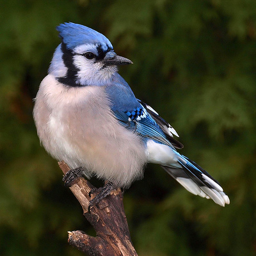

reconstructed image:


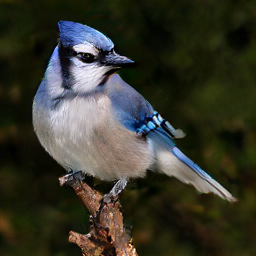

In [12]:
tokenize_and_reconstruct("assets/ILSVRC2012_val_00010240.png")

## Generate an image from 32 discrete tokens

labels 831, studio couch, day bed


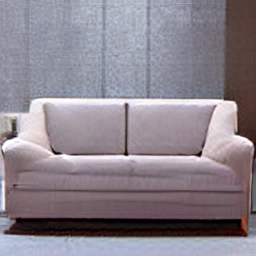

In [13]:
sample_labels = [torch.randint(0, 999, size=(1,)).item()]

# The guidance_scale and randomize_temperature can be adjusted to trade-off between quality and diversity.
generated_image = demo_util.sample_fn(
    generator=titok_generator,
    tokenizer=titok_tokenizer,
    labels=sample_labels,
    guidance_scale=3.5,
    randomize_temperature=1.0,
    num_sample_steps=8,
    device=device
)

for i in range(generated_image.shape[0]):
    print(f"labels {sample_labels[i]}, {imagenet_classes.imagenet_idx2classname[sample_labels[i]]}")
    display(Image.fromarray(generated_image[i]))